In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import backend as K
import numpy as np
from tensorflow.keras import layers
from random import sample

# Encoder

In [ ]:
original_dim = 32 * 32 * 3
intermediate_dim = 64
latent_dim = 1500

inputs = tf.keras.Input(shape=(32,32,3))
x = tf.keras.layers.Conv2D(16, (3,3), padding='SAME', activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.Conv2D(32, (3,3), padding='SAME', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2)(x)

shape = x.shape

h = tf.keras.layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 32)   4640        max_pooling2d_2[0][0]            
____________________________________________________________________________________________

# Decoder

In [ ]:
# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
units = shape[1] * shape[2] * shape[3]
x = layers.Dense(units, activation='relu')(latent_inputs)
#Reshape
x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]), name='decode_reshape')(x)

#UpSampling
x = tf.keras.layers.Conv2D(32, (3,3), padding='SAME', activation='relu')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2D(16, (3,3), padding='SAME', activation='relu')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
outputs = tf.keras.layers.Conv2D(3, (3,3), padding='SAME', activation='sigmoid')(x)

decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
print(decoder.summary())
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 1500)]            0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              3074048   
_________________________________________________________________
decode_reshape (Reshape)     (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 16)        4624      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 32, 32, 16)        0   

In [ ]:
reconstruction_loss = K.sum(K.sum(tf.keras.losses.binary_crossentropy(inputs, outputs),axis=2),axis=1)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss,axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, x_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Epoch 1/20
1563/1563 [==============================] - 15s 9ms/step - loss: 1862969.9390 - val_loss: 1782295.2500
Epoch 2/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1777936.1593 - val_loss: 1775232.8750
Epoch 3/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1766486.3123 - val_loss: 1767883.2500
Epoch 4/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1763064.7391 - val_loss: 1764157.3750
Epoch 5/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1760422.9971 - val_loss: 1764915.1250
Epoch 6/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1758671.3061 - val_loss: 1760089.5000
Epoch 7/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1756264.7084 - val_loss: 1758811.3750
Epoch 8/20
1563/1563 [==============================] - 13s 9ms/step - loss: 1756039.6582 - val_loss: 1756685.5000
Epoch 9/20
1563/1563 [====================

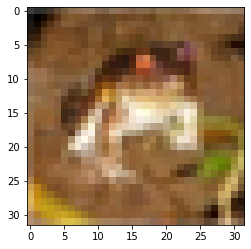

In [ ]:
plt.imshow(x_train[0])
plt.show()

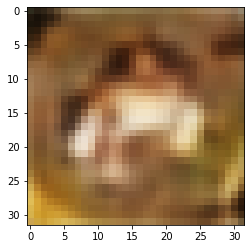

In [ ]:
prediction = vae.predict((x_train[0])[np.newaxis,...])
plt.imshow(prediction[0])
plt.show()

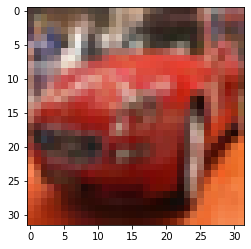

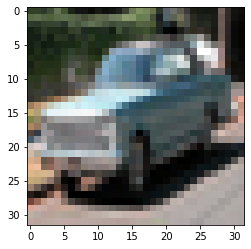

(1, 1500)


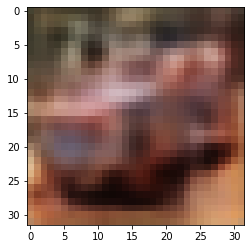

In [ ]:
lst = x_train[y_train.reshape(-1) == 1][1:3]
plt.imshow(np.flip(lst[0],axis=1))
plt.show()
plt.imshow(lst[1])
plt.show()

encode1 = encoder.predict((np.flip(lst[0],axis=1))[np.newaxis,...])[0]
encode2 = encoder.predict((lst[1])[np.newaxis,...])[0]

decode_mean = (encode1 + encode2) / 2. 

z_sample = np.array([decode_mean])
z_sample = z_sample.reshape((1,1500))
print(z_sample.shape)
prediction = decoder.predict(z_sample)
plt.imshow(prediction[0])
plt.show()

# Encoder 2

In [ ]:
inputs = tf.keras.Input(shape=(32,32,3))
x = tf.keras.layers.Conv2D(16, (3,3), padding='SAME', activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, (3,3), padding='SAME', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)

shape = x.shape

h = tf.keras.layers.Flatten()(x)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [ ]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 16)   64          max_pooling2d_4[0][0]            
____________________________________________________________________________________________

# Decoder 2

In [ ]:
# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
units = shape[1] * shape[2] * shape[3]
x = layers.Dense(units, activation='relu')(latent_inputs)
#Reshape
x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]), name='decode_reshape')(x)

#UpSampling
#x = tf.keras.layers.Conv2D(64, (3,3), padding='SAME', activation='relu')(x)
#x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.Conv2D(32, (3,3), padding='SAME', activation='relu')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(16, (3,3), padding='SAME', activation='relu')(x)
x = tf.keras.layers.UpSampling2D(2)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Conv2D(3, (3,3), padding='SAME', activation='sigmoid')(x)
#outputs = tf.keras.layers.Reshape((28, 28, 1), name='decode_reshape')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
print(decoder.summary())
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 1500)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              3074048   
_________________________________________________________________
decode_reshape (Reshape)     (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 16)        4624

In [ ]:
reconstruction_loss = K.sum(K.sum(tf.keras.losses.binary_crossentropy(inputs, outputs),axis=2),axis=1)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss,axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape)
print(x_test.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

vae.fit(x_train, x_train,
        epochs=20,
        batch_size=32,
        validation_data=(x_test, x_test))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
Epoch 1/20
1563/1563 [==============================] - 16s 9ms/step - loss: 1866928.9967 - val_loss: 1791006.0000
Epoch 2/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1783117.3831 - val_loss: 1771237.3750
Epoch 3/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1774247.0855 - val_loss: 1764696.1250
Epoch 4/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1764054.4664 - val_loss: 1759916.1250
Epoch 5/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1761482.8760 - val_loss: 1758601.8750
Epoch 6/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1758417.2796 - val_loss: 1754526.6250
Epoch 7/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1757543.5453 - val_loss: 1758880.5000
Epoch 8/20
1563/1563 [==============================] - 14s 9ms/step - loss: 1753165.6512 - val_loss: 1753379.7500
Epoch 9/20
1563/1563 [====================

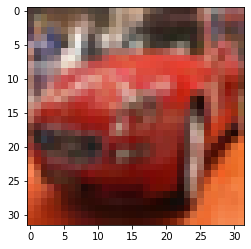

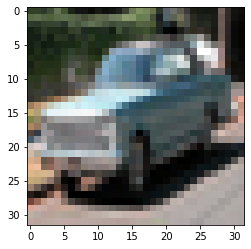

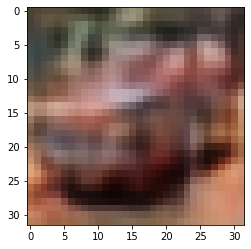

In [ ]:
lst = x_train[y_train.reshape(-1) == 1][1:3]
plt.imshow(np.flip(lst[0],axis=1))
plt.show()
plt.imshow(lst[1])
plt.show()

encode1 = encoder.predict((np.flip(lst[0],axis=1))[np.newaxis,...])[0]
encode2 = encoder.predict((lst[1])[np.newaxis,...])[0]

decode_mean = (encode1 + encode2) / 2. 

z_sample = np.array([decode_mean])
z_sample = z_sample.reshape((1,1500))
prediction = decoder.predict(z_sample)
plt.imshow(prediction[0])
plt.show()